In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, classes = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [277]:
datasize = 90
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [278]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [279]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[90, 90, 90, 90]


## Split data

In [280]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [281]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 360 total docs, 252 train and 108 test


### Initialize Vectorizer

In [282]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 3640


### Prepare Datatset

In [283]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [284]:
# reduce freq in doc to bin value of 1 or 0
binary = False

word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

if binary:
    wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
    wdf_test = (word_doc_frequency_norm_test > 0).astype(int)
    
else:    
    wdf_train = word_doc_frequency_norm_train.copy()
    wdf_test = word_doc_frequency_norm_test.copy()

## Word Topic Probability Distr

In [285]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
topic_doc_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_doc_count[category]
    word_topic_pr_distr[category] = pxy * (topic_doc_count[category] / word_doc_count)

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (3640, 4)


In [286]:
word_topic_pr_distr.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
00,0.411765,0.000000,0.000000,0.588235
000,0.000000,0.208628,0.791372,0.000000
000mi,1.000000,0.000000,0.000000,0.000000
02,1.000000,0.000000,0.000000,0.000000
034101,0.000000,0.000000,0.000000,1.000000


In [287]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

Topwords: Topic - sci.space


sub            1.0
ireland        1.0
jacked         1.0
thruster       1.0
acad3          1.0
billionaire    1.0
wall           1.0
gummint        1.0
depend         1.0
isp            1.0
Name: sci.space, dtype: float64

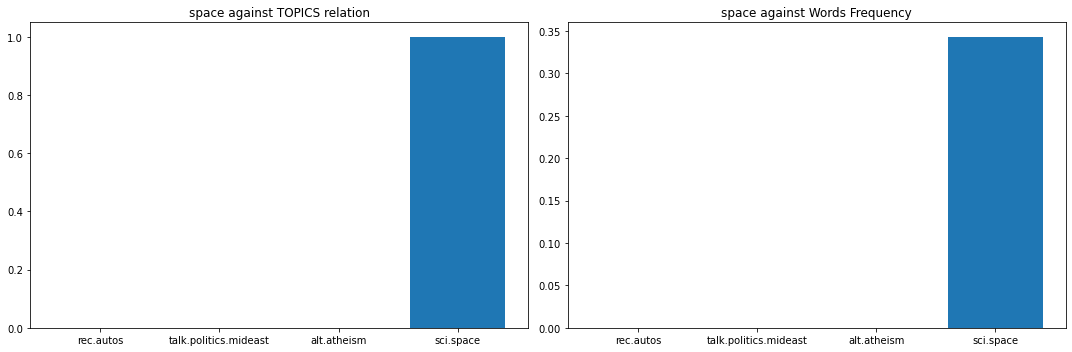

In [288]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

In [289]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

Document: 0, Topic: alt.atheism
hey glad to have some serious and constructive contributor in this newsgroup i agree 100 on the statement above you might argue with bobby for eon and he still do not get it so the best thing be to spare your mental resource to discus more interest issue cheer kent



In [290]:
doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

Inference: Document 0
actual = alt.atheism, predicted = alt.atheism



In [291]:
print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

Topwords: Document 0
to       0.061224
the      0.040816
and      0.040816
thing    0.020408
bobby    0.020408
argue    0.020408
eon      0.020408
it       0.020408
Name: 0, dtype: float64


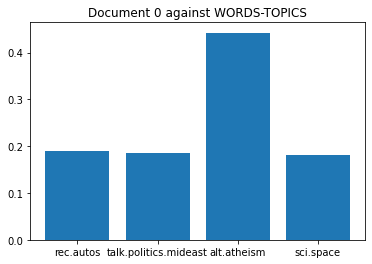

In [292]:
plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [327]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"train accuracy = {train_accuracy: .2f}%")


train accuracy =  100.00%


## Topic Word Distr - Test Accuracy

In [328]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  84.26%


In [329]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")

overall_accuracy =  92.13%


### Word Word Probability Distr

In [295]:
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3640, 3640)


In [296]:
word_word_pr_distr.head()

,00,000,000mi,02,034101,04110,07,0710,09,0988,...,yup,zealand,zepher,zero,zillion,zion,zionism,zionist,zip,zlumber
00,1.0,0.0,0.411765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000mi,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [297]:
word = "science"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr[word].sort_values(ascending=False).head(10)

Topwords: Word - science


extent            1.0
earthing          1.0
origin            1.0
sometime          1.0
larc              1.0
afraid            1.0
movie             1.0
inhabitant        1.0
science           1.0
macroevolution    1.0
Name: science, dtype: float64

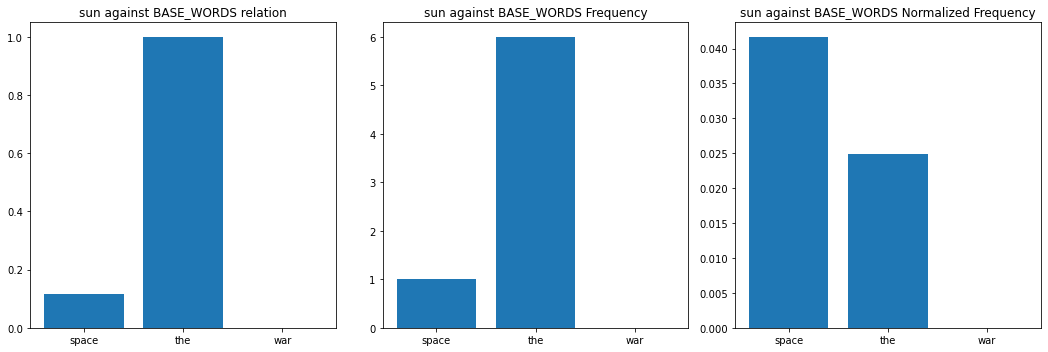

In [298]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

## Word distr 2

In [299]:
word_word_pr_distr2 = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr2[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3640, 3640)


In [300]:
word = "science"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr2[word].sort_values(ascending=False).head(10)

Topwords: Word - science


publish     0.020000
325ix       0.020000
awd         0.020000
325         0.020000
autoweek    0.020000
94          0.020000
afraid      0.017544
biggist     0.017544
whils       0.017544
extent      0.017544
Name: science, dtype: float64

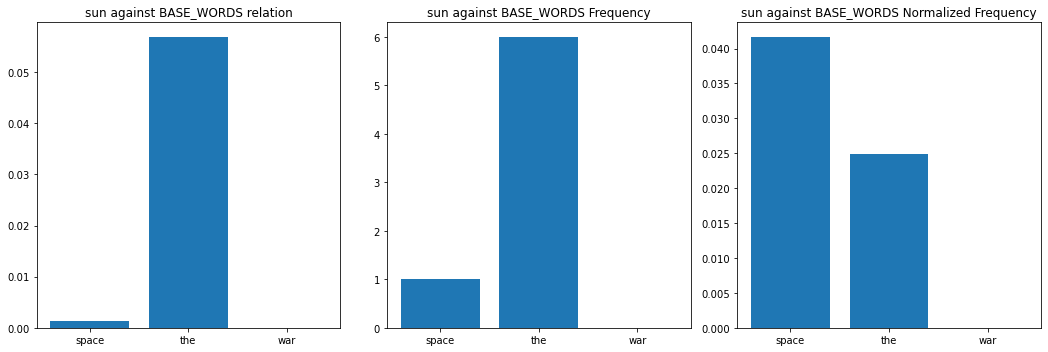

In [301]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr2.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

### Montecarlo method

In [358]:
# reduce freq in doc to bin value of 1 or 0
binary = False
test_size = 0.5
alpha, beta = 0.0, 1.0
num_of_iterations = 256
max_num_of_iterations = None
train_sample_accuracy_threshold, test_sample_accuracy_threshold = 0.5, 0.5

assert (alpha + beta) == 1.0, "Alpha and Beta don't add up to 1.0"

# the prime distr
gamma_sum = 0
n_iter = n_all_iter = 0
word_topic_pr_distr_prime = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

total_iterations = num_of_iterations if max_num_of_iterations is None else max_num_of_iterations

with tqdm(total=total_iterations) as pbar:
    while True:
        if max_num_of_iterations is None and n_iter >= num_of_iterations:
            break
            
        if max_num_of_iterations is not None and n_all_iter >= max_num_of_iterations:
            break
        
        n_all_iter += 1
        if max_num_of_iterations is not None:
            pbar.update(1)
            
        x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(x_train, y_train, test_size=test_size)

        # create doc count vectors
        train_doc_vectors_sample = vectorizer.transform(x_train_sample).toarray()
        test_doc_vectors_sample = vectorizer.transform(x_test_sample).toarray()

        word_freq_in_doc_train_sample = pd.DataFrame(train_doc_vectors_sample, columns=vocabulary)
        word_freq_in_doc_test_sample = pd.DataFrame(test_doc_vectors_sample, columns=vocabulary)

        word_doc_frequency_norm_train_sample = (word_freq_in_doc_train_sample.T / word_freq_in_doc_train_sample.sum(1)).T
        word_doc_frequency_norm_test_sample = (word_freq_in_doc_test_sample.T / word_freq_in_doc_test_sample.sum(1)).T

        if binary:
            wdf_train_sample = (word_doc_frequency_norm_train_sample > 0).astype(int)
            wdf_test_sample = (word_doc_frequency_norm_test_sample > 0).astype(int)

        else:    
            wdf_train_sample = word_doc_frequency_norm_train_sample.copy()
            wdf_test_sample = word_doc_frequency_norm_test_sample.copy()

        wdt_train_sample = wdf_train_sample.copy()
        wdt_test_sample = wdf_test_sample.copy()

        wdt_test_sample["__labels__"] = y_test_sample
        wdt_train_sample["__labels__"] = y_train_sample

        word_doc_count_sample = wdf_train_sample.sum(0)
        topic_doc_count_sample = pd.DataFrame(Counter(y_train_sample), index=[0]).T[0]
        word_topic_pr_distr_sample = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

        for category in (categories):
            pxy = wdf_train_sample[wdt_train_sample["__labels__"] == category].sum(0) / topic_doc_count_sample[category]
            word_topic_pr_distr_sample[category] = pxy * (topic_doc_count_sample[category] / word_doc_count_sample)

        # print(f"word_topic_pr_distr_sample shape = {word_topic_pr_distr_sample.shape}")
            
        score_train_sample = 0
        for doc_index in (range(len(y_train_sample))):
            doc_vector = wdf_train_sample.loc[doc_index]
            _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_sample)

            mark = wdt_train_sample.loc[doc_index]['__labels__'] == predicted_doc_topic
            score_train_sample += mark
            
        train_accuracy_sample = score_train_sample / len(y_train_sample)
        # print(f"train accuracy_sample = {train_accuracy_sample * 100: .2f}%")
        
        if train_accuracy_sample <= train_sample_accuracy_threshold:
            continue
            
        score_test_sample = 0
        for doc_index in (range(len(y_test_sample))):
            doc_vector = wdf_test_sample.loc[doc_index]
            _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_sample)

            mark = wdt_test_sample.loc[doc_index]['__labels__'] == predicted_doc_topic
            score_test_sample += mark

        test_accuracy_sample = score_test_sample / len(y_test_sample)
        # print(f"test accuracy_sample = {test_accuracy_sample * 100: .2f}%")
        
        if test_accuracy_sample <= test_sample_accuracy_threshold:
            continue
            
        # the forward factor
        gamma = (alpha * train_accuracy_sample) + (beta * test_accuracy_sample)

        # updating the word_topic_distr_prime
        gamma_sum += gamma
        word_topic_pr_distr_prime += (gamma * word_topic_pr_distr_sample)
        
        n_iter += 1
        if max_num_of_iterations is None:
            pbar.update(1)
            
#         gamma_sum += 1
#         word_topic_pr_distr_prime += word_topic_pr_distr_sample
        
print(f"Ran {n_iter} iteration(s) that fit constraint! {n_all_iter} iteration(s) in total!")


Ran 256 iteration(s) that fit constraint! 283 iteration(s) in total!


## Word Topic Probability Distr Prime

In [359]:
n_iter, gamma_sum, test_accuracy_sample

(256, 157.14285714285728, 0.6507936507936508)

In [360]:
# replace nan with 0
word_topic_pr_distr_prime = word_topic_pr_distr_prime.fillna(0) / gamma_sum

print(f"word_topic_pr_distr_prime shape = {word_topic_pr_distr_prime.shape}")

word_topic_pr_distr_prime shape = (3640, 4)


In [361]:
word_topic_pr_distr_prime.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
00,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0
000mi,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0
034101,0.0,0.0,0.0,0.0


In [362]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr_prime[topic].sort_values(ascending=False).head(10)

Topwords: Topic - sci.space


orbit     1.000000
space     1.000000
low       0.780524
large     0.767765
cost      0.743773
idea      0.696462
expect    0.653735
base      0.633068
ago       0.591389
while     0.574024
Name: sci.space, dtype: float64

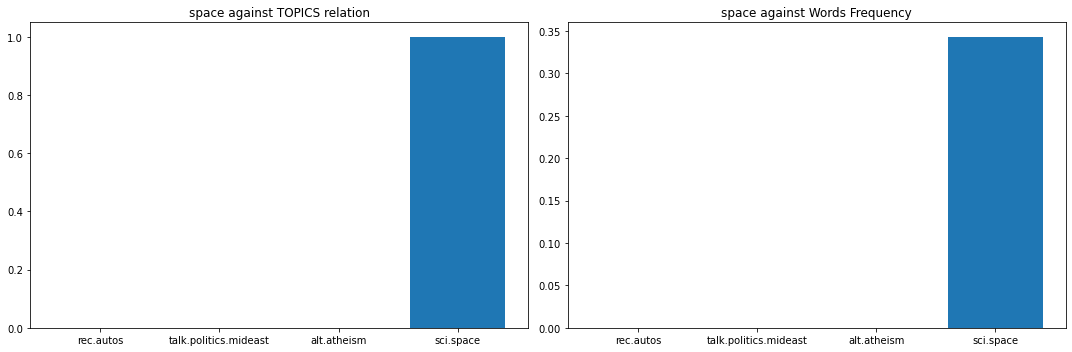

In [363]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr_prime.columns, word_topic_pr_distr_prime.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr_prime.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr_prime.columns, freqs)

plt.show()

### Quick Topic Inference

In [364]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

Document: 0, Topic: alt.atheism
hey glad to have some serious and constructive contributor in this newsgroup i agree 100 on the statement above you might argue with bobby for eon and he still do not get it so the best thing be to spare your mental resource to discus more interest issue cheer kent



In [365]:
doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

Inference: Document 0
actual = alt.atheism, predicted = alt.atheism



In [366]:
print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

Topwords: Document 0
to       0.061224
the      0.040816
and      0.040816
thing    0.020408
bobby    0.020408
argue    0.020408
eon      0.020408
it       0.020408
Name: 0, dtype: float64


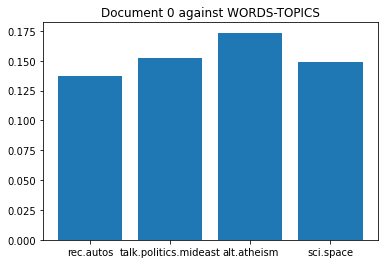

In [367]:
plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [368]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"accuracy = {train_accuracy: .2f}%")


accuracy =  84.13%


## Topic Word Distr - Test Accuracy

In [369]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  53.70%


In [370]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")

overall_accuracy =  68.92%
